# COGS 108 - Final Project



## Names
Justin Martinez

Brendan Chou

Xiaohan Sun

Kevin Estrada Garcia

Jarrett Cornelison


### Overview

- COVID-19 is an ongoing pandemic that has infected over 7 million and killed 400,000 globally: in our highly interconnected world, such a phenomenon may occur again the future
- We want to know which is a better indication of how well a nation has handled the virus: its HDI rating or how early on the first case was detected within their territory
- Our findings found that a relatively strong correlation between a nation's HDI and COVID-19's morality rate within their territory

## Research Question
Which is a stronger indication of how well a nation handled the COVID-19 outbreak: their HDI score or the date they announced their first confirmed case?


## Background and Prior Work
 
COVID-19 is an abbreviation that needs no introduction - millions have beared witness to the drastic and sweeping changes the novel coronavirus has brought upon the world throughout the course of 2020. Key industries face elevated risk of contraction and collapse, economies across the world have been thrown into stagnation, and virtually nobody has been left unaffected by its wake. Symptoms may range across the entire spectrum from virtually nonexistent to life-threatening, and without a vaccine to prevent its spread, extremely contagious person-to-person transmission remains one of the hallmark characteristics and challenges set forth by COVID-19. With over 7 million cases worldwide and counting, the unprecedented scale of the novel coronavirus outbreak continues to make its mark on the world.  

In the event of any catastrophe, adequate preparation and prevention strategies are often cited as key factors in minimizing casualties and losses. How early a nation reported its first confirmed case in relation to the timeline of the outbreak may be an important figure when considering how success major nations have been at containing the spread and impact of the virus within their respective territories. Conventional wisdom seems to imply that nations that reported their first case during the earlier stages in the outbreak were able to better handle the virus than those that did not.

Another possible metric that could be used as a basis of comparison is the human development index (HDI). The calculation of the human development index takes life expectancy, average years of education, and income/standards of living into account. Nations with a higher HDI rating tend to be more developed and allow for improved quality of life, which among many things, includes easier accessibility to adequate medical infrastructure. Following this reasoning, nations with a higher HDI rating should have greater ability to shelter and provide medical resources to citizens during the outbreak compared to those with a lower HDI rating.

In this investigation, how well or poorly a nation has handled the virus will be determined by the ratio of deaths to the number of confirmed cases. 


## Hypothesis

We expect to find in our analysis that HDI score will be a stronger indication of COVID-19 preparedness than the date of the first observation - considering the nature of how the HDI is calculated, nations with a higher HDI should generally fare better than those with a lower HDI.


In [1]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import requests
import bs4
from bs4 import BeautifulSoup

## Datasets
Fill in your dataset information here


Dataset Name: covid_19_data

- Link to the dataset: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset?select=covid_19_data.csv

- Number of observations: 35,201

- Description: In this dataset, there is information on the number of COVID-19 cases for many countries across the world on specific dates starting from January 22, 2020. We are specifically looking to extract the date of the first reported case for each nation in the dataset.


Dataset Name: 2019 HDI report (web scraped)

- Link to the third dataset: https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index

- Number of observations in the third dataset: 189

- Description: In this dataset, the calculated HDI is provided for each country/territory along with their average annual growth rate from 2010-2018. We are only concerned with the HDI score in this context.



Dataset Name: Coronavirus Update (web scraped)

- Link to the second dataset: https://www.worldometers.info/coronavirus/?

- Number of observations in the second dataset: 215

- Description: In this dataset, several statistics on the coronavirus outbreak are provided for each observation, including the number of total cases, total deaths, total recoveries, and the total population.


We are going to combine these datasets by merging the values from the the HDI dataset and the date of the first reported case from the covid_19_data dataset with the global COVID-19 statistics dataset in order to create one single dataset that has all the information required to test our hypothesis. 

## SetUp

### Obtain Dataset on the Date of the First Confirmed Case

Let's start by importing our csv file that stores several COVID-19 statistics on several nations, including the date of the every observed case, the number of confirmed cases, deaths, and recoveries in each particular instance.

In [2]:
df = pd.read_csv("covid_19_data.csv")
df = df.reset_index(drop=True)
df = df[df.Confirmed != 0]
df = df.drop_duplicates(subset ="Country/Region", keep = "first", inplace = False)
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
20,21,01/22/2020,Macau,Macau,1/22/2020 17:00,1.0,0.0,0.0
28,29,01/22/2020,Taiwan,Taiwan,1/22/2020 17:00,1.0,0.0,0.0
31,32,01/22/2020,Washington,US,1/22/2020 17:00,1.0,0.0,0.0
35,36,01/22/2020,NaN,Japan,1/22/2020 17:00,2.0,0.0,0.0


### Obtain Dataset on 2019 Human Development Index

We will need a column in our dataframe that stores the HDI of each nation/territory. The following code is used to web scrape data from https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index. It only includes the columns titled "Country" and "HDI"

In [3]:
wiki="https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index"
page = requests.get(wiki).text
soup = BeautifulSoup(page, 'html.parser')

In [4]:
HDI_table=soup.find("table", {"class": "wikitable sortable"})

In [5]:
list_name, list_HDI = [], []

for row in HDI_table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells) != 5:
        continue
    list_name.append(cells[2].find('a').text)
    list_HDI.append(cells[3].find(text=True))

In [6]:
df_HDI=pd.DataFrame(list_name,columns=['Country'])
df_HDI['HDI']=list_HDI

This dataframe stores nations/territories along with their assigned HDI score. Notice how there are only 190 observations in this dataframe compared to the 221 in the previous dataframe cotaining the dates of the first confirmed case. Because we will eventually merge these dataframes together and all observations will be expected to have a value for each column, the size of our final dataframe is upper bounded by the size of the smallest dataframe. In this particular case, we can only expect a maximum of 190 observations in our dataframe, and that's assuming that every nation in the HDI dataframe appears in the covid_19_data dataframe

In [7]:
df_HDI

,Country,HDI
0,Norway,0.954
1,Switzerland,0.946
2,Ireland,0.942
3,Germany,0.939
4,Hong Kong,0.939
...,...,...
185,Burundi,0.423
186,South Sudan,0.413
187,Chad,0.401
188,Central African Republic,0.381


### Obtain Live Dataset on Coronavirus Statistics

Scrape data from https://www.worldometers.info/coronavirus/. Include only the columns titled "Country", "Total Cases", and "Total Deaths'

In [8]:
wiki="https://www.worldometers.info/coronavirus/"
page = requests.get(wiki).text
soup = BeautifulSoup(page, 'html.parser')

In [9]:
right_table=soup.find('table')

In [10]:
list_name, list_totalCases, list_totalDeaths, list_totalPopulation = [], [], [], []

for row in right_table.findAll('tr'):
    
    cells = row.findAll('td')
    # Skips rows that aren't 19 columns long (like the heading)
    if len(cells) != 19:
        continue
    if cells[0].find(text=True):
        if (cells[1].find('a')):
            list_name.append(cells[1].find('a').text)
        else:
            list_name.append(cells[1].find('span').text)
        list_totalCases.append(cells[2].find(text=True))
        list_totalDeaths.append(cells[4].find(text=True))
        if (cells[14].find('a')):
            list_totalPopulation.append(cells[14].find('a').contents[0])
        else:
            list_totalPopulation.append(cells[14].find(text=True))
    # This catches when the name cells stops having a link
    #  and ends, skipping the last (summary rows)
#list_totalPopulation

In [11]:
df_coronaStats=pd.DataFrame(list_name,columns=["Country"])
df_coronaStats["Total Cases"]=list_totalCases
df_coronaStats["Total Deaths"]=list_totalDeaths
df_coronaStats["Total Population"]=list_totalPopulation



This dataframe stores the most important figures like case and death numbers for 215 different nations/territories. Notice how there are some blank values in the death count for some territories near the end of the dataframe. These are typically indicative of very small populations with few infected individuals. Because our measure of coronavirus handling will be treated as the death rate (death count/total cases), these smaller territories without any confirmed deaths could very easily skew our results because it would appear as if their death rate was 0% (and it technically is, but that doesn't make for a good measure of how well that particular territory has handled the virus). We will handle the observations with blank values later in the process.

Since the smallest of these three datasets is df_HDI with 190 observations, the maximum possible size of our final dataframe is 190 observations.

In [12]:
df_coronaStats

,Country,Total Cases,Total Deaths,Total Population
0,USA,"2,066,508","115,137","330,896,410"
1,Brazil,"775,184","39,797","212,475,738"
2,Russia,"493,657","6,358","145,931,211"
3,UK,"290,143","41,128","67,866,605"
4,Spain,"289,360","27,136","46,753,838"
...,...,...,...,...
210,St. Barth,6,,"9,875"
211,Lesotho,4,,"2,141,301"
212,Anguilla,3,,"14,995"
213,Saint Pierre Miquelon,1,,"5,795"


## Data Cleaning
Include cells that describe the steps in your data analysis.

Notice that there are slight spelling variations in the names of the countries/territories. When we merge our datasets into one, we'll need the name of the countries to match up perfectly so all the data from our columns match with the correct observations. A standardizing function to handle names will be needed. We define the function lowercase to make all region names lowercase and manually adjust regions that represent the same area with different names in both datasets. Special cases were included to catch commmon abbreviations, such as 'US' and 'USA'.

In [13]:
def lowercase(string):
    
    output = string.lower()
    if 'united states' in output:
        output = 'united states'
    #to avoid bundling us with russia
    elif output=='us':
        output = 'united states'
    elif output=='usa':
        output = 'united states'
    #to avoid bundling uk with ukraine
    elif output == 'uk':
        output = 'united kingdom'
    elif 'china' in output:
        output = 'mainland china'
    elif 'russia' in output:
        output = 'russia'
    elif 'tanzania' in output:
        output = 'tanzania'
    elif 'venezuela' in output:
        output = 'venezuela'
    elif 'viet' in output:
        output = 'vietnam'
    elif 'bolivia' in output:
        output = 'bolivia'
    elif 'south sudan' in output:
        output = 'south sudan'
    elif 'sudan' in output:
        output = 'sudan'
    elif 'syria' in output:
        output = 'syria'
    elif 'moldova' in output:
        output = 'moldova'
    elif 'republic of korea' in output:
        output = 'south korea'
    elif 'philippines' in output:
        output = 'philippines'
    #niger!=nigeria
    elif output=='niger':
        output = 'niger'
    elif 'lao' in output:
        output = 'laos'
    elif 'gambia' in output:
        output = 'gambia'
    elif 'dominican republic' in output:
        output = 'dominican republic'
    elif 'iran' in string:
        output = 'iran'
    elif 'democratic rep. of the congo' in output:
        output = 'congo (kinshasa)'
    elif 'congo (the)' in output:
        output = 'congo (brazzaville)'
    elif 'comoros' in output:
        output = 'comoros'
    elif 'central african republic' in output:
        output = 'central african republic'
        
    return output



Let's use this lowercase function now to standardize the Country/Region columns of each dataset

In [14]:
df['Country/Region'] = df['Country/Region'].apply(lowercase)
df = df.drop_duplicates(subset ="Country/Region", keep = "last", inplace = False)
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,mainland china,1/22/2020 17:00,1.0,0.0,0.0
20,21,01/22/2020,Macau,macau,1/22/2020 17:00,1.0,0.0,0.0
28,29,01/22/2020,Taiwan,taiwan,1/22/2020 17:00,1.0,0.0,0.0
31,32,01/22/2020,Washington,united states,1/22/2020 17:00,1.0,0.0,0.0
35,36,01/22/2020,NaN,japan,1/22/2020 17:00,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
12387,12388,04/06/2020,NaN,sao tome and principe,4/6/20 9:37,4.0,0.0,0.0
13705,13706,04/10/2020,NaN,yemen,2020-04-10 23:01:43,1.0,0.0,0.0
19963,19964,04/30/2020,NaN,comoros,2020-05-01 02:32:28,1.0,0.0,0.0
20090,20091,04/30/2020,NaN,tajikistan,2020-05-01 02:32:28,15.0,0.0,0.0


In [15]:
df_HDI['Country']=df_HDI['Country'].apply(lowercase)
df_HDI

,Country,HDI
0,norway,0.954
1,switzerland,0.946
2,ireland,0.942
3,germany,0.939
4,hong kong,0.939
...,...,...
185,burundi,0.423
186,south sudan,0.413
187,chad,0.401
188,central african republic,0.381


In [16]:
df_coronaStats['Country'] = df_coronaStats['Country'].apply(lowercase)
df_coronaStats

,Country,Total Cases,Total Deaths,Total Population
0,united states,"2,066,508","115,137","330,896,410"
1,brazil,"775,184","39,797","212,475,738"
2,russia,"493,657","6,358","145,931,211"
3,united kingdom,"290,143","41,128","67,866,605"
4,spain,"289,360","27,136","46,753,838"
...,...,...,...,...
210,st. barth,6,,"9,875"
211,lesotho,4,,"2,141,301"
212,anguilla,3,,"14,995"
213,saint pierre miquelon,1,,"5,795"


Notice in the first dataframe that our observation dates are stored in dd/mm/yyyy format. This is standard date convention but for our purposes, we want to store this value as an integer. Because the first reported cases were early in 2020, we decided to arrange a column that stored the observation date as the number of days that have passed since January 1, 2020 (meaning the United States would be assigned the value 22 since its first reported cases was on 1/22/20). 

We define a function observation_date, which will read in the dates listed in the ObservationDate column and assign them a numerical value that is equivalent to the number of days the date is from the start of the new year. We go up to June because that is the last month for which data has been obtained.

In [17]:
def observation_date(string):
    arr = string.split('/')
    arr = arr[0:2]
    tot = 0
    if arr[0] == '01':
        tot += 0
    elif arr[0] == '02':
        tot += 31
    elif arr[0] == '03':
        tot += 60
    elif arr[0] == '04':
        tot += 91
    elif arr[0] == '05':
        tot += 121
    elif arr[0] == '06':
        tot += 152
    sumDate = int(arr[1]) + tot
    return sumDate

Let's call the observation_date function on our first dataframe to standardize the date format and store it in a column called ObservationDays. All that's left to do for this dataframe is to drop the original ObservationDate column along with the other unused columns to minimize clutter in our final dataframe (SNo,Province/State,Last Update, Confirmed, Deaths, and Recovered). Our final dataframe should store only the country name and the number of days it took since the start of 2020 to report its first confirmed case

In [18]:
df['ObservationDays'] = df['ObservationDate'].apply(observation_date)
df=df.drop(['SNo','ObservationDate', 'Province/State','Last Update','Confirmed','Deaths','Recovered'],axis=1)
df=df.rename(columns={"Country/Region":"Country"})
df=df.reset_index(drop=True)
df

,Country,ObservationDays
0,mainland china,22
1,macau,22
2,taiwan,22
3,united states,22
4,japan,22
...,...,...
216,sao tome and principe,97
217,yemen,101
218,comoros,121
219,tajikistan,121


The only modification we need to make to our HDI dataframe is to convert the HDI column (currently storing objects/strings)into floats. This will be used during our calculations later

In [19]:
df_HDI['HDI']=df_HDI['HDI'].astype(float)
df_HDI

,Country,HDI
0,norway,0.954
1,switzerland,0.946
2,ireland,0.942
3,germany,0.939
4,hong kong,0.939
...,...,...
185,burundi,0.423
186,south sudan,0.413
187,chad,0.401
188,central african republic,0.381


Remember from earlier that our Coronavirus stats dataframe that stored the bulk of the data had some observations where the death count was empty (equivalent to 0). Instead of dropping these rows direclty for being empty, a better practice is to store these values with 0s instead so they don't cause any problems during the merging process. We'll apply this modification to both the "Total Deaths" and "Total Population columns. We know the total cases column is never blank/empty (if it were, that country/territory wouldn't be listed on the website) and we don't want to accidentally replace the whitespaces in our country names with 0's (united states!=united0states). 

We apply this change to the total population column because if you visit the Coronavirus live website (https://www.worldometers.info/coronavirus/) and scroll down, you'll notice that some populations are actually left blank as well! That doesn't make sense - how can a population of any territory be 0? As it turns out, one or two of the "territories" marked on the website aren't actual territories, but unique physical locations where a concentrated number of cases emerged. For example, observation #132 on the website is "Diamond Princess" - that's not a country or a territory, that's the cruise ship where an outbreak emerged while passengers were on board. The passengers have since been evacuated, so the population is now down to 0.

Like we did with df_HDI, let's convert our numerical columns into their respective formats. Total cases, deaths, and population should be integers instead of objects/strings

In [20]:
df_coronaStats['Total Deaths'] = df_coronaStats['Total Deaths'].replace(' ','0', regex=True)
df_coronaStats['Total Population'] = df_coronaStats['Total Population'].replace(' ','0', regex=True)
df_coronaStats = df_coronaStats.replace(',','', regex=True)
df_coronaStats['Total Cases'] = df_coronaStats['Total Cases'].astype(int)
df_coronaStats['Total Deaths'] = df_coronaStats['Total Deaths'].astype(int)
df_coronaStats['Total Population'] = df_coronaStats['Total Population'].astype(int)
df_coronaStats

,Country,Total Cases,Total Deaths,Total Population
0,united states,2066508,1151370,330896410
1,brazil,775184,397970,212475738
2,russia,493657,63580,145931211
3,united kingdom,290143,411280,67866605
4,spain,289360,271360,46753838
...,...,...,...,...
210,st. barth,6,0,9875
211,lesotho,4,0,2141301
212,anguilla,3,0,14995
213,saint pierre miquelon,1,0,5795


### Merge Coronavirus stats dataframe with HDI dataframe

Now that all the datasets have been individually prepared, it's time to begin merging the datasets together into one. Let's start by merging df_coronStats and df_HDI dataframes into a finalized dataframe called df_final. It should contain the total cases, total deaths, total population, and HDI after this merge.

In [21]:
df_final = df_coronaStats.merge(df_HDI,left_on='Country', right_on='Country')
df_final

,Country,Total Cases,Total Deaths,Total Population,HDI
0,united states,2066508,1151370,330896410,0.920
1,brazil,775184,397970,212475738,0.761
2,russia,493657,63580,145931211,0.824
3,united kingdom,290143,411280,67866605,0.920
4,spain,289360,271360,46753838,0.893
...,...,...,...,...,...
164,saint kitts and nevis,15,0,53178,0.777
165,seychelles,11,0,98314,0.801
166,papua new guinea,8,0,8936574,0.543
167,lesotho,4,0,2141301,0.518


### Merge all our data to one dataframe
Now let's merge df_final with our first dataframe, df, and store it in df_final again. This finalized dataframe should now contain all the data we need (total cases, total deaths, total population, HDI, and the number of days taken to report the first case). There are 168 observations in this dataframe - a bit lower than our largest possible size of 190. It simply means that there were a total of 22 observations that showed up in one or more dataframes but not all three.

In [22]:
df_final = df_final.merge(df, left_on='Country', right_on='Country')
df_final

,Country,Total Cases,Total Deaths,Total Population,HDI,ObservationDays
0,united states,2066508,1151370,330896410,0.920,22
1,brazil,775184,397970,212475738,0.761,57
2,russia,493657,63580,145931211,0.824,31
3,united kingdom,290143,411280,67866605,0.920,31
4,spain,289360,271360,46753838,0.893,32
...,...,...,...,...,...,...
163,saint kitts and nevis,15,0,53178,0.777,85
164,seychelles,11,0,98314,0.801,74
165,papua new guinea,8,0,8936574,0.543,80
166,lesotho,4,0,2141301,0.518,134


Notice again that there are observations in our final dataframe with 0s in the total deaths column. We avoided dropping columns simply because they were blank because it's important to understand why a column value might be blank before dropping it. Because our analysis is aimed at the major nations of the world and we don't want to take countries with very small populations or minimal case sizes into account (doing so would likely skew our results in favor of smaller, remote countries), we can begin arranging threshold values for which observations that fall below should be dropped.

Firstly, we want to make sure that every territory/nation in our analysis has had a significant outbreak. We'll define that in this context by setting the threshold value at 10,000 - any observation with less than 10,000 coronavirus cases is taken out of consideration - this will remove observations that don't belong in our analysis like Diamond Princess and MS Zaandam. Secondly, we want to make sure that our observations are indeed signficant nations. We'll define that in this context by setting the threshold value at 10,000,000 - any observation with a population of less than 10,000,000 is taken out of consideration. With these two conditions, our remaining dataframe stores 50 observations - significantly less than the 168 we initially had.

In [23]:
df_final=df_final[df_final['Total Cases']>=10000]
df_final=df_final[df_final['Total Population']>=5000000]
df_final=df_final.sort_values(by=["HDI"])
df_final=df_final.reset_index(drop=True)
df_final

,Country,Total Cases,Total Deaths,Total Population,HDI,ObservationDays
0,afghanistan,22890,4260,38872577,0.496,55
1,nigeria,13873,3820,205808201,0.534,59
2,pakistan,119536,23560,220626768,0.560,57
3,ghana,10358,480,31032265,0.596,74
4,bangladesh,74865,10120,164596070,0.614,68
5,india,287155,81070,1379233699,0.647,30
6,iraq,15414,4260,40165118,0.689,55
7,egypt,38284,13420,102215478,0.700,45
8,bolivia,15281,5120,11663656,0.703,71
9,south africa,55421,12100,59265120,0.705,65


Below is a bar graph that with HDI set as the y-axis

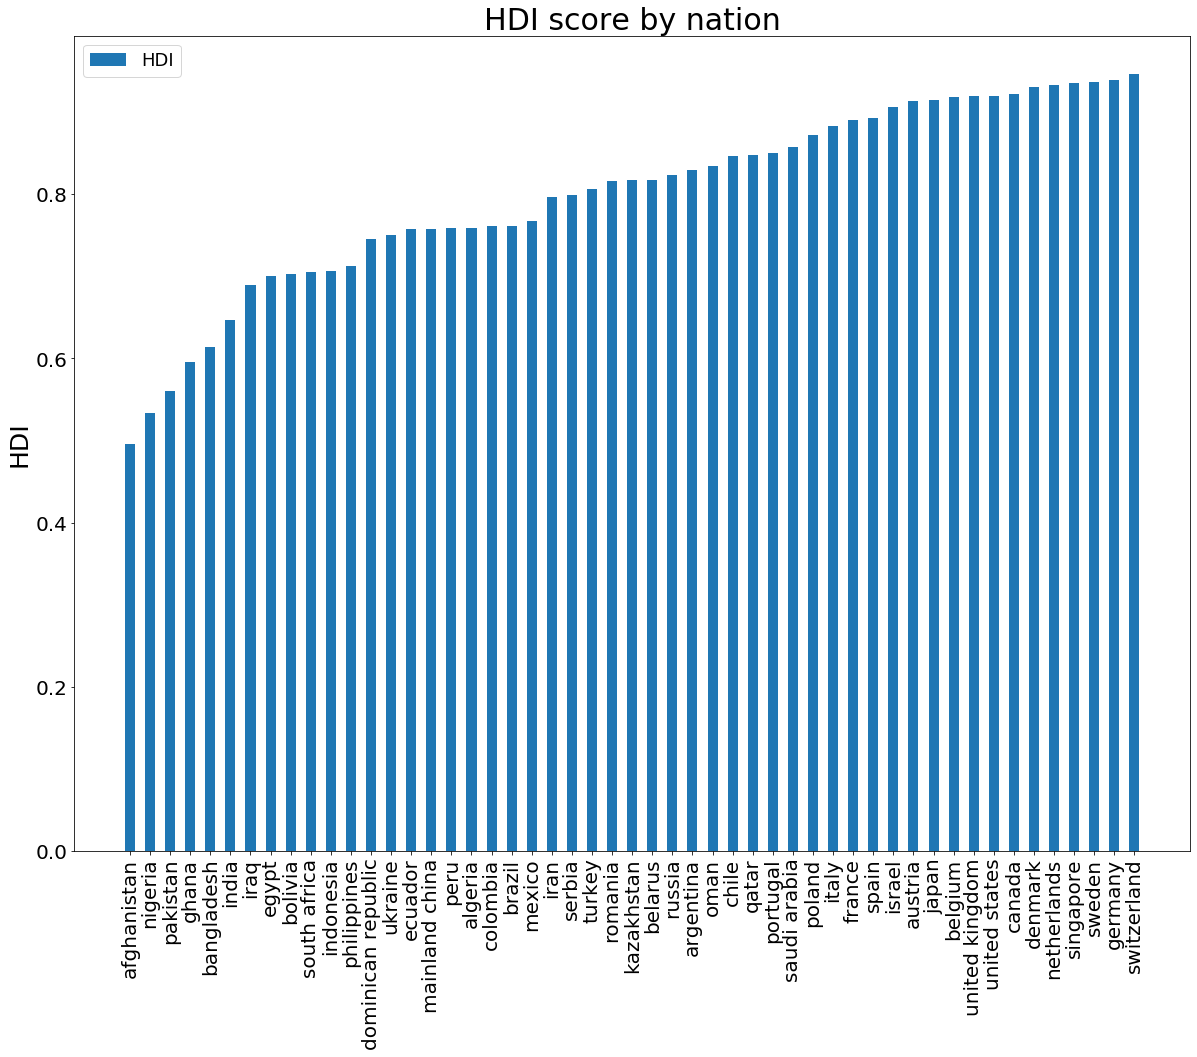

In [24]:
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
f,HDI = plt.subplots(figsize=(20,15))
plt.xticks(rotation=90)
plt.bar(df_final['Country'],df_final['HDI'],width=0.5,label = 'HDI')
HDI.set_title('HDI score by nation',fontsize=30)
HDI.set_ylabel('HDI',fontsize=25)
HDI.legend(fontsize = 18)

Below is a bar graph that with ObservationDays set as the y-axis. Let's sort it by ObservationDate for easier viewing

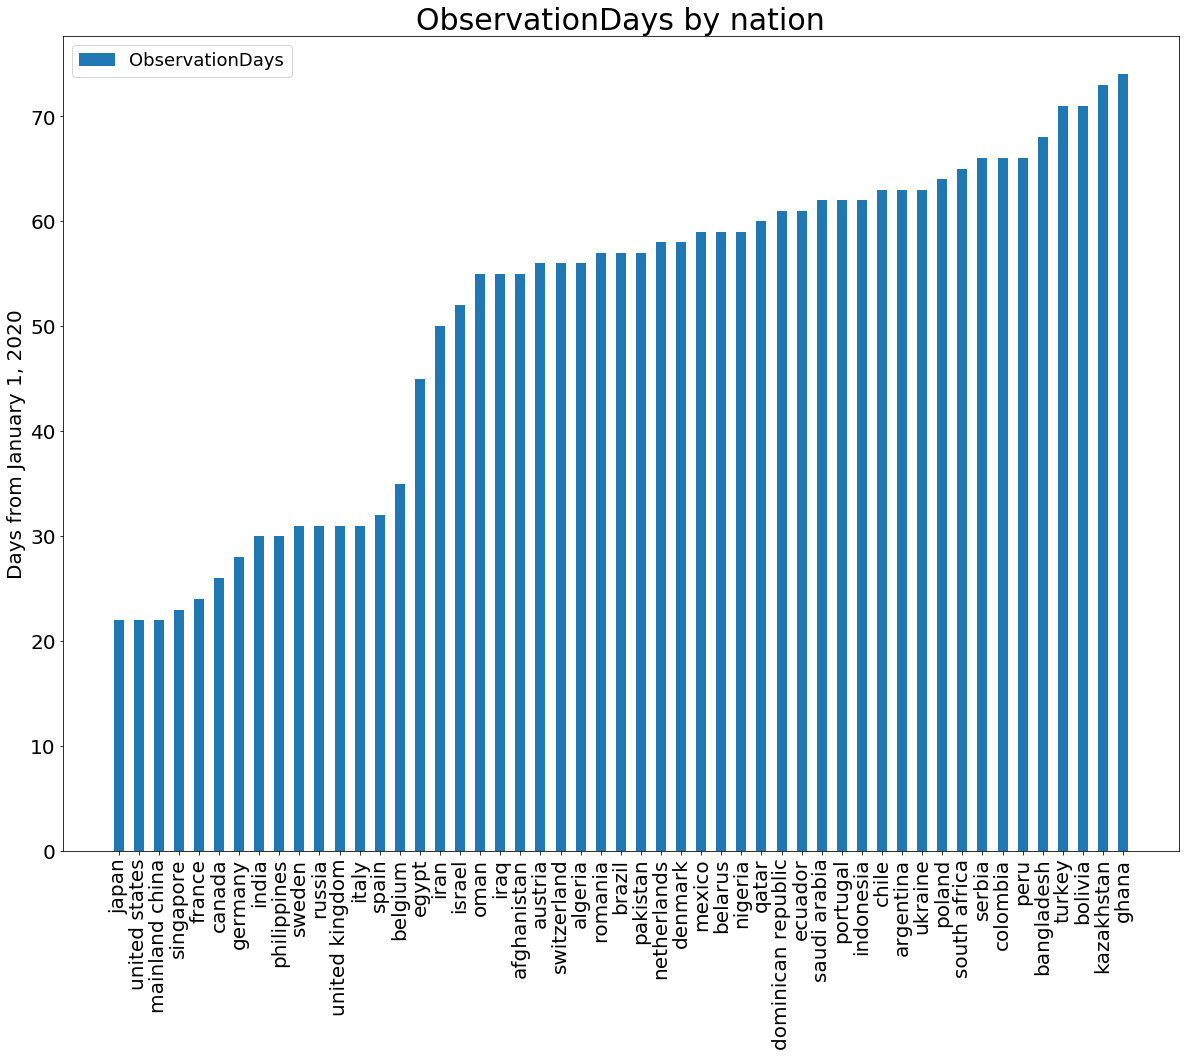

In [25]:
df_final=df_final.sort_values(by=["ObservationDays"])
f,OD = plt.subplots(figsize=(20,15))
plt.xticks(rotation=90)
plt.bar(df_final['Country'],df_final['ObservationDays'],width=0.5,label = 'ObservationDays')
OD.set_title('ObservationDays by nation',fontsize=30)
OD.set_ylabel('Days from January 1, 2020',fontsize=20)
OD.legend(fontsize = 18)

## Data Analysis And Results

Now that we've collected all the necessary data for our analysis, let's begin by plotting a histogram for the HDI of the nations in our dataframe. To get an idea of what range we should consider when plotting the x-axis, we'll first take the max and min HDI values frm our dataframe. It's important to manually set this range because when we compare plots with HDI values a bit later, we want our frame of reference (the x-axis) to remain static regardless of what values are plotted to avoid misleading graphs

In [26]:
print(df_final['HDI'].max())
print(df_final['HDI'].min())

0.946
0.496


Text(0, 0.5, 'Frequency')

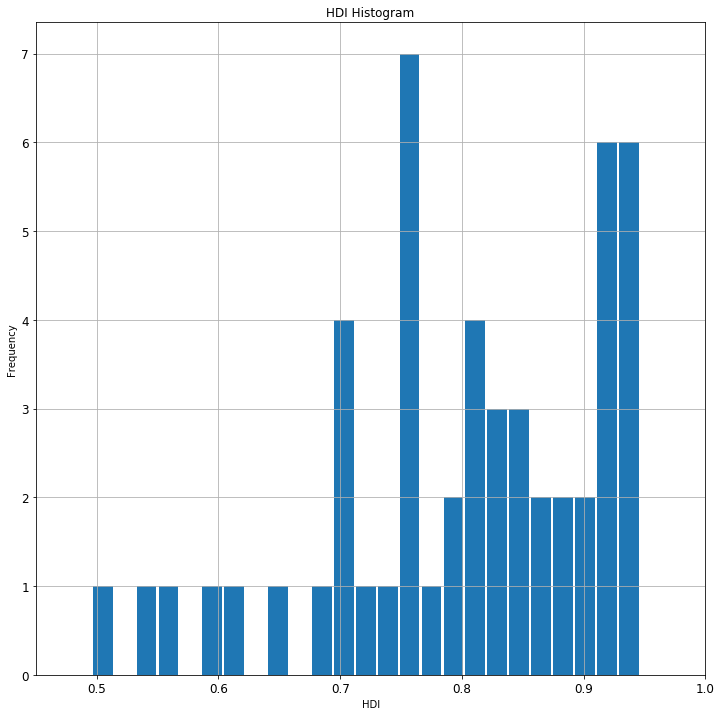

In [27]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

plt.figure(figsize=(12,12))
histo = pd.Series(df_final['HDI'])
histo.plot.hist(grid=True, bins=25, rwidth=0.9,)
plt.xlim([0.45,1.0])
plt.title('HDI Histogram')
plt.xlabel('HDI')
plt.ylabel('Frequency')

In [28]:
df_final['HDI'].mean()

0.7999607843137255

The plot seems to be skewed to the left with a majority of HDI score lying somewhere between 0.7 and 0.8 and a secondary peak at 0.9. This indicates that the majority of the nations in our graph have a higher HDI with a few outliers on the left end of the bell curve

Again, we'll take the max and min values from the ObservationDate Int column to find a reasonable scale to use for our plot. We set the x-axis range from 20 to 75 days to cover the full range of values

In [29]:
print(df_final['ObservationDays'].max())
print(df_final['ObservationDays'].min())

74
22


Text(0, 0.5, 'Frequency')

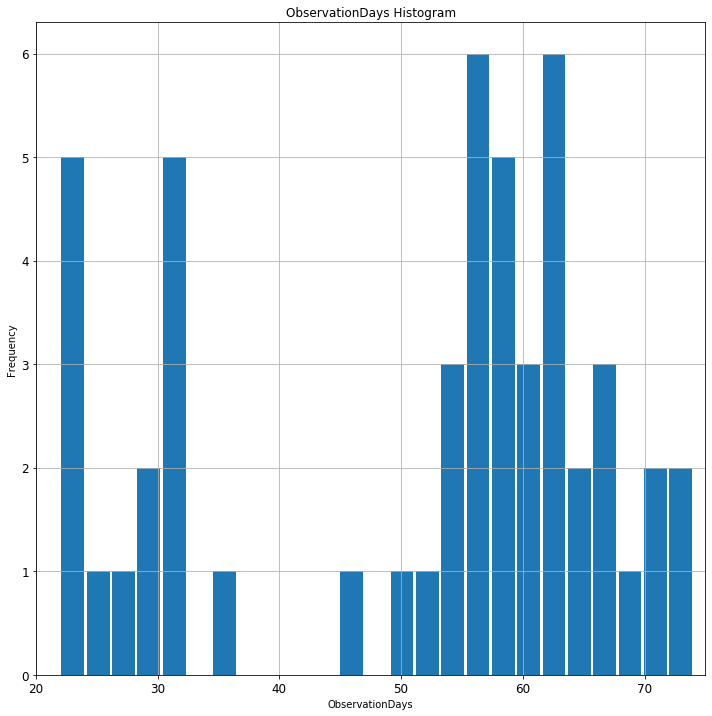

In [30]:
plt.figure(figsize=(12,12))
histo = pd.Series(df_final['ObservationDays'])
histo.plot.hist(grid=True, bins=25, rwidth=0.9,)
plt.xlim([20,75])
plt.title('ObservationDays Histogram')
plt.xlabel('ObservationDays')
plt.ylabel('Frequency')

The histogram here shows a bimodal distribution with a peak (two peaks in close proximity) occuring somewhere between the 20 and 30th day of the year (mid/late January) and the second occuring around the 60th day of the year (late February/early March). There's also a few outliers that reported their first confirmed case somewhere between 40 and 50 days in the year (mid February).

In [31]:
st_HDI,p_HDI=stats.normaltest(df_final['HDI'])
st_ObservationDays,p_ObservationDays=stats.normaltest(df_final['ObservationDays'])
print(p_HDI)
print(p_ObservationDays)

0.06376677608337201
0.004500882328147899


The results can be interpreted depending on where the alpha value is set to. Using the norm of 0.05, it seems as if we can call the distribution of HDI scores as normal despite being appeared to be skewed leftward. The distribution of Observation Days fails our normal test and cannot be called a normal distribution, which is quite obvious considering the bimodal result on the graph

Let's see if we can get a general idea of the HDI of the nations that fall in the first and second peak in our ObservationDays histogram

In [32]:
df_first_peak = df_final[df_final['ObservationDays']<=40]
df_second_peak = df_final[df_final['ObservationDays']>40]

Text(0, 0.5, 'Frequency')

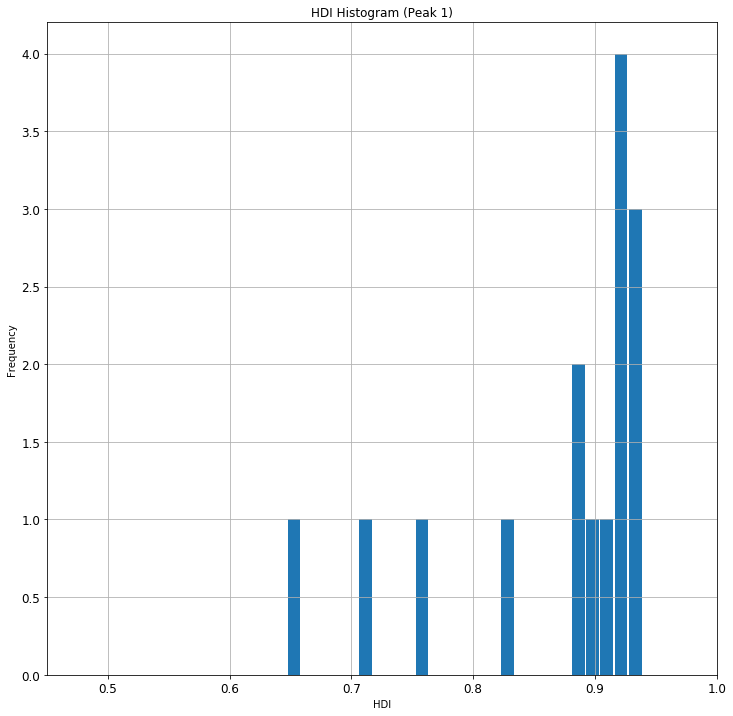

In [33]:
plt.figure(figsize=(12,12))
histo = pd.Series(df_first_peak['HDI'])
histo.plot.hist(grid=True, bins=25, rwidth=0.9,)
plt.xlim([0.45,1])
plt.title('HDI Histogram (Peak 1)')
plt.xlabel('HDI')
plt.ylabel('Frequency')

In [34]:
df_first_peak['HDI'].mean()

0.8676666666666667

We see that most of the nations within the first peak (those that reported their first case within the first 40 days of 2020) have an HDI rating considerably higher than that of the overall group, averaging at about 0.867 compared to the average's 0.799. This could be for a number of reasons for this observation, the most likely being the fact that COVID-19 testing/screening was made available in wealthier, technically advanced nations first. Nations with a higher HDI also tend to be popular destination hotspots for international travel, facilitating the spread of the outbreak to these countries.

Text(0, 0.5, 'Frequency')

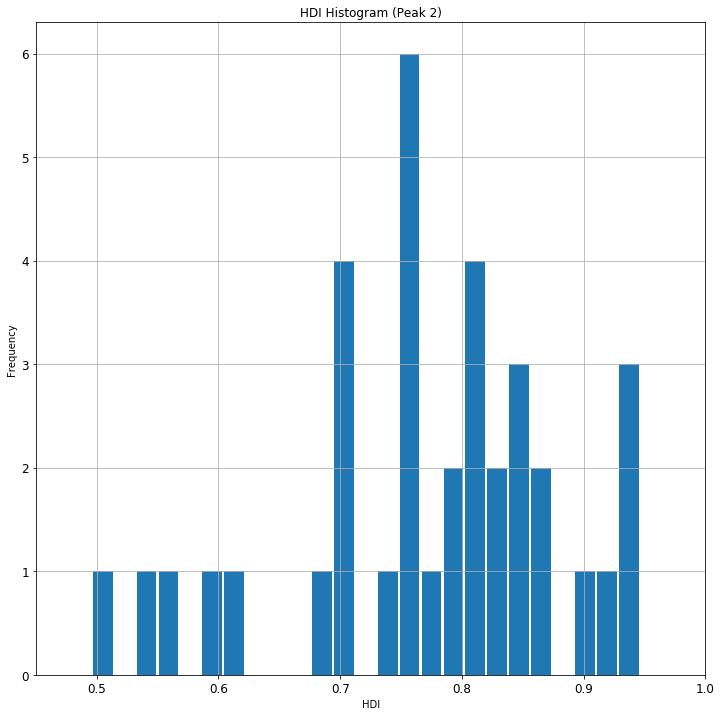

In [35]:
#sns.distplot(df_second_peak['HDI'], bins=25);
#plt.xlim([0.45,1])
#f4 = plt.gcf()

plt.figure(figsize=(12,12))
histo = pd.Series(df_second_peak['HDI'])
histo.plot.hist(grid=True, bins=25, rwidth=0.9,)
plt.xlim([0.45,1])
plt.title('HDI Histogram (Peak 2)')
plt.xlabel('HDI')
plt.ylabel('Frequency')

In [36]:
df_second_peak['HDI'].mean()

0.77175

Three t-tests were run to determine if there was a statistically significant different between the mean HDI of the two peaks, between the first peak and the full distribution, and between the second peak and the full distribution.


In [37]:
ttest, pval = ttest_ind(df_first_peak['HDI'], df_second_peak['HDI'])
print("p-value:",pval)
if pval <0.05:
  print("We reject the null hypothesis.")
else:
  print("We fail to reject the null hypothesis.")

p-value: 0.004807368349414553
We reject the null hypothesis.


The null hypothesis is rejected, meaning the mean HDI between the two peaks are significantly different. This is not surprising, given that the two peaks are the furthest apart

In [38]:
ttest, pval = ttest_ind(df_first_peak['HDI'], df_final['HDI'])
print("p-value:",pval)
if pval <0.05:
  print("We reject the null hypothesis.")
else:
  print("We fail to reject the null hypothesis.")

p-value: 0.03835334689141593
We reject the null hypothesis.


The null hypothesis here is also rejected, meaning the mean HDI between the first peak and the normal HDI distribution is still significantly different, although considerably less so than the two peaks.

In [39]:
ttest, pval = ttest_ind(df_second_peak['HDI'], df_final['HDI'])
print("p-value:",pval)
if pval <0.05:
  print("We reject the null hypothesis.")
else:
  print("We fail to reject the null hypothesis.")

p-value: 0.25246960344467645
We fail to reject the null hypothesis.


The null hypothesis here is not rejected, meaning the mean HDI between the second peak and the normal HDI distribution is not significantly different. This is not surprising, considering the normal bell curve HDI distribution in the second peak and the small difference between its mean HDI with that of the original HDI distribution.

The HDI ratings are more evenly distributed across the spectrum in nations within the second peak (those that reported their first case sometime after the first 40 days of 2020), with the mean falling between 0.7 and 0.8 (confirmed by our t-test that it is not significantly different than the mean HDI of the entire dataset). The average HDI of nations in the second peak is 0.771, falling slightly below the general average of 0.799. Possible reasons for this could include a lack of testing availability and travel restrictions that may have been set in place at this point in the outbreak. Generally speaking, nations that reported an earlier first confirmed case have a higher HDI rating, although the question as to which one is a better indication of COVID-19 preparedness remains unaswered

To begin comparing our analysis of how these independent variables affect our dependent variable (death rate), let's create a column that stores the ratio of total deaths over the number of total columns into a column called "Death/Case Ratio". This will give us an idea of how well each nation has "handled" the outbreak of the virus (in our analysis, limiting death is considered the metric of success)

In [40]:
df_final['DeathCaseRatio'] = np.divide(df_final['Total Deaths'],df_final['Total Cases'])
df_final

,Country,Total Cases,Total Deaths,Total Population,HDI,ObservationDays,DeathCaseRatio
40,japan,17251,9190,126495892,0.915,22,0.532723
43,united states,2066508,1151370,330896410,0.920,22,0.557157
15,mainland china,83057,46340,14393237760,0.758,22,0.557930
47,singapore,38965,250,5847776,0.935,23,0.006416
36,france,155136,293190,65265877,0.891,24,1.889890
44,canada,97125,79600,37723541,0.922,26,0.819562
49,germany,186866,88440,83769646,0.939,28,0.473280
5,india,287155,81070,1379233699,0.647,30,0.282321
11,philippines,23732,10270,109495553,0.712,30,0.432749
48,sweden,46814,47950,10095806,0.937,31,1.024266


In [41]:
outcome,predictors = patsy.dmatrices('DeathCaseRatio ~ HDI',df_final)

In [42]:
mod=sm.OLS(outcome,predictors)
res=mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         DeathCaseRatio   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     9.211
Date:                Wed, 10 Jun 2020   Prob (F-statistic):            0.00384
Time:                        23:56:03   Log-Likelihood:                -25.286
No. Observations:                  51   AIC:                             54.57
Df Residuals:                      49   BIC:                             58.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7317      0.408     -1.794      0.0

With the Death/Case Ratio as the dependent variable and HDI set as the independent variable, the effect size (coef) is 1.536 and the p-value is 0.004, meaning for every 1 unit increase in HDI, you could expect to see a 1.536 unit increase in the number of deaths over the number of cases. It's a fairly steep slope that indicates some relationship between the two variables. Let's try investigating our other independent variable, the number of days before the first observed case, to see if our results are similar there

In [43]:
outcome,predictors = patsy.dmatrices('DeathCaseRatio ~ ObservationDays',df_final)

In [44]:
mod=sm.OLS(outcome,predictors)
res=mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         DeathCaseRatio   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     12.69
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           0.000832
Time:                        23:56:03   Log-Likelihood:                -23.807
No. Observations:                  51   AIC:                             51.61
Df Residuals:                      49   BIC:                             55.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.1203      0.184     

With the Death/Case Ratio as the dependent variable and ObservationDays set as the independent variable, the effect size is -0.0123 and the p-value is 0.001, meaning for every 1 unit increase in ObservationDays, you could only expect to see a 0.0123 decrease in the number of deaths over the number of cases, meaing that on average, our death rate actually drops ever so slightly the longer a nation takes to report its first case. We see a very weaker relationship between ObservationDays and Death/Case Ratio compared to HDI, indicating that HDI may be the stronger predictor of the two.

Correlation between DeathCaseRatio and HDI: 0.3977794119564472


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


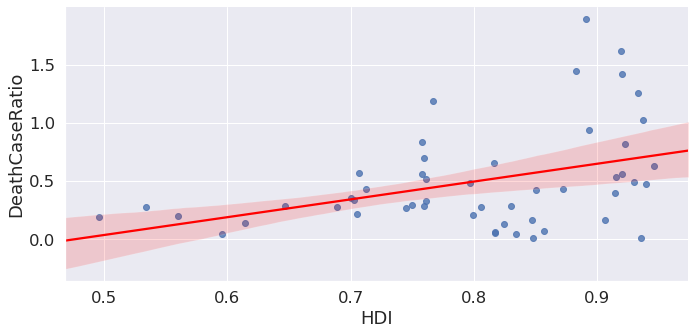

In [45]:
print("Correlation between DeathCaseRatio and HDI: " + str(df_final['DeathCaseRatio'].corr(df_final['HDI'])))
sns.set(font_scale=1.5)
sns.lmplot(x='HDI', y='DeathCaseRatio', data=df_final, aspect=2, line_kws={'color':'red'});
f5 = plt.gcf()

Coupled along with the results of the OLS test, we do see a positive correlation between HDI and death rate: the higher a nation's HDI rating, the higher its death/cases ratio tends to be. These results suggest that there is a tangible relationship bewtween the two. However, take note of the positioning of the points throughout the graph. The line of best fit captures the first few points fairly well, but as HDI increases beyond a certain point the individual points begin to scatter further and further away. Linear regression relies on homoscedasticity, or when the variation between the points remains fairly constant throughout the plot. These results indicate that linear regression should not be used to draw a relationship between these two variables

As for the findings themselves: don't nations with a higher HDI score have longer average lifespans due with improved quality of life? This is true, but it's also important to consider that the novel coronavirus in particular has a much higher mortality rate in the elderly. Also taking into account the fact that nations with higher HDI ratings have older citizens on average (explained with the demographic transition model in greater detail later), it seems reasonable that nations with a higher HDI may suffer greater losses despite having superior medical infrastructure.

Let us plot a correlation graph between DeathCaseRatio and ObservationDays to see if our negative relationship there is similar to our findings on the OLS test

Correlation between DeathCaseRatio and ObservationDays: -0.45349152233406564


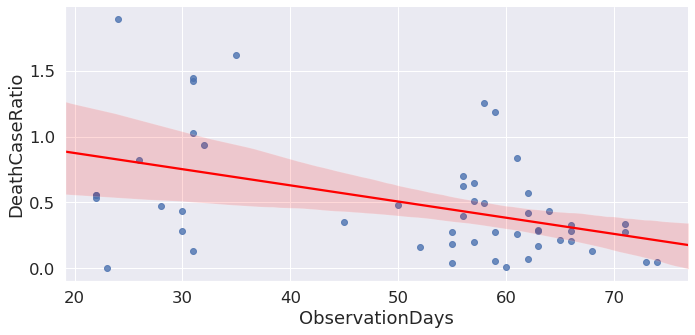

In [46]:
print("Correlation between DeathCaseRatio and ObservationDays: " + str(df_final['DeathCaseRatio'].corr(df_final['ObservationDays'])))
sns.lmplot(x='ObservationDays', y='DeathCaseRatio', data=df_final, aspect=2, line_kws={'color':'red'});
f6 = plt.gcf()

We're seeing a generally negative correlation stronger than what was suggested by OLS - on average, a nation's death/case ratio tends to be lower the longer it took to report its first confirmed case. This comes back to the reasoning mentioned earlier - we know that nations that took beyond 40 days to report their first case generally have a lower HDI than those that did not. Nations with a lower HDI tend to be in the earlier stages of the demographic transition model, where fewer members of the population are elderly and thus less susceptible to death from COVID-19

This scatterplot appears to suffer from even greater variation than the first - points on the lower end of ObservationDays are all over the place and deviate wildly from our regression line. Variation decreases near the right end of the graph but quite a bit of variation remains as the line of best fit struggles to properly represent the points. It seems rather clear from these results that the relationship between HDI and Death/Cases is more prominent than the relationship between Observation Days and Death/Cases.

The correlation matrix below is a summary of our correlation graphs. Despite being ObservationDays and Death/Cases producing the steeper slope, we found that the relationship was weak and that the line of regression did a poor job of capturing the points.

(3.0, 0.0)

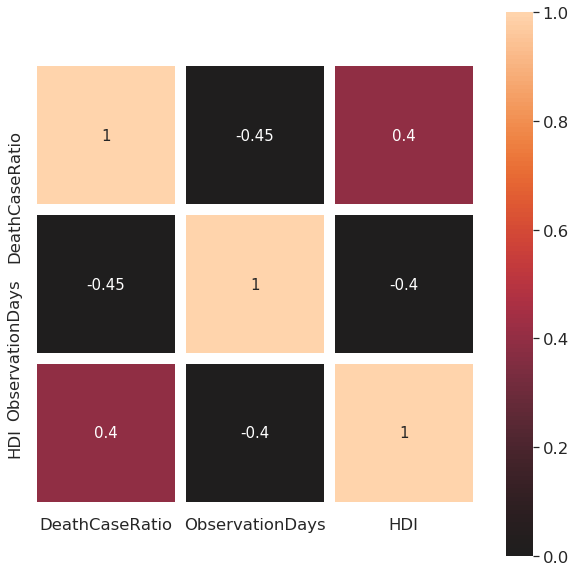

In [47]:
df = pd.DataFrame(df_final,columns=['DeathCaseRatio', 'ObservationDays', 'HDI'])

plt.figure(figsize=(10, 10))
corrMatrix = df.corr()
ax=sns.heatmap(corrMatrix,vmin=0, vmax=1, center=0,square=True, linewidths=10,annot=True,annot_kws={"size": 15})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Discussion of a Possible Confounding Variable

Considering the circumstances of our analysis, it may be worthwhile to consider possible confounding variables at play. As mentioned in the beginning our analysis, HDI is a factor that measures a nation's general wellbeing and generally scales upwards with the stages of the demographic transition model, a theoretical model that observes changes with birth rates, death rates, and population size/demographics as nations and societies naturally progress through "stages" of advancement. 

Typical characteristics of a nation in the 4th/5th stage of the demographic transition model include low birth and death rates with a very slight decline in population size, compared to exponential population growth caused by falling death rates and a relatively high birth rate during the 3rd stage of the model. These changes are also reflected in the population demographics - nations in first two or three stages have younger populations on average, with this being represented in the vertical pyramid by a wider base that tapers near the top as relatively few individuals living in these societies reach old age. 

As a nation progresses into the 4th and especially the 5th stage, the shape of the pyramid changes drastically - the base gradually narrows down as the birth rate falls and the tip of the pyramid widens as the death rate falls, resulting in a figure that resembles a hill rather than a pyramid. The factors that catalyze and trigger advancement through the five stages include improvements in medical infrastructure and healthcare, more years of general education, and improved social/economic opportunities for citizens, which happen to be the factors used to calculate a nation's HDI. Consequently, the average age of citizens in a nation in the later stages of the DTM/higher HDI value tends to be significantly higher than average. For example, the mean ages of citizens living in Japan and Germany are 47.3 and 47.1 years respectively, which is over double Pakistan's mean age of 22.8 years

![Demographic Transition Model](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Demographic-TransitionOWID.png/1220px-Demographic-TransitionOWID.png)

We now know that average age is indeed factor in a nation's HDI, but what about COVID-19 deaths? As it turns out, the novel coronavirus outbreak has generally been considered fatal only to those above a certain age threshold and has even been dubbed by some demographics of the internet as "the boomer remover" for its disproportionately high mortality rate in elderly populations. Considering that age is known to be a factor in both HDI and the COVID-19 morality rate, there is a highly likelyhood that age is acting as a confounding variable that has more to do with the two variables than those variables do themselves.

Although we do not have direct access to COVID-19 statistics on an individual level and cannot stratify the data to isolate age as a cofounding variable, we can redefine our current metric of "success" to possibly avoid this shortcoming. Instead of considering "success" as the death rate, we can consider the infection rate in relation to a nation's total population size. This definition should not be as dependent on age as the death rate since ongoing research does not seem to indicate a significant discrepancy between how susceptible an individual is to catching infection based on age alone. Since we already have the total population count in our dataframe, we can use this to create a new column called CasePopulationRatio

In [48]:
df_final['CasePopulationRatio'] = np.divide(df_final['Total Cases'],df_final['Total Population'])
df_final

,Country,Total Cases,Total Deaths,Total Population,HDI,ObservationDays,DeathCaseRatio,CasePopulationRatio
40,japan,17251,9190,126495892,0.915,22,0.532723,0.000136
43,united states,2066508,1151370,330896410,0.920,22,0.557157,0.006245
15,mainland china,83057,46340,14393237760,0.758,22,0.557930,0.000006
47,singapore,38965,250,5847776,0.935,23,0.006416,0.006663
36,france,155136,293190,65265877,0.891,24,1.889890,0.002377
44,canada,97125,79600,37723541,0.922,26,0.819562,0.002575
49,germany,186866,88440,83769646,0.939,28,0.473280,0.002231
5,india,287155,81070,1379233699,0.647,30,0.282321,0.000208
11,philippines,23732,10270,109495553,0.712,30,0.432749,0.000217
48,sweden,46814,47950,10095806,0.937,31,1.024266,0.004637


In [49]:
outcome,predictors = patsy.dmatrices('CasePopulationRatio ~ HDI',df_final)
mod=sm.OLS(outcome,predictors)
res=mod.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     CasePopulationRatio   R-squared:                       0.286
Model:                             OLS   Adj. R-squared:                  0.272
Method:                  Least Squares   F-statistic:                     19.66
Date:                 Wed, 10 Jun 2020   Prob (F-statistic):           5.22e-05
Time:                         23:56:06   Log-Likelihood:                 252.12
No. Observations:                   51   AIC:                            -500.2
Df Residuals:                       49   BIC:                            -496.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0055      0.002     -3.10

With the Infection/Population Ratio as the dependent variable and HDI set as the independent variable, the effect size (coef) is 0.0098 and the p-value is 0, meaning for every 1 unit increase in HDI, you could expect to see a marginal 0.0098 unit increase in the national infection rate. It's a significantly smaller effect size than the coef of 1.5341 that we saw when Death/Case Ratio was set as the dependent variable, indicating that age was most likely a cofounding variable that skewed our initial results

The positive effect size implies that there still remains a very slight increase in infection rates as a nation's HDI rises.  Possible reasoning for this could be improved testing availability of nations within the upper echelons of the HDI rankings. 

In [50]:
outcome,predictors = patsy.dmatrices('CasePopulationRatio ~ ObservationDays',df_final)
mod=sm.OLS(outcome,predictors)
res=mod.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     CasePopulationRatio   R-squared:                       0.066
Model:                             OLS   Adj. R-squared:                  0.047
Method:                  Least Squares   F-statistic:                     3.439
Date:                 Wed, 10 Jun 2020   Prob (F-statistic):             0.0697
Time:                         23:56:06   Log-Likelihood:                 245.25
No. Observations:                   51   AIC:                            -486.5
Df Residuals:                       49   BIC:                            -482.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0039      

With the Infection/Population Ratio as the dependent variable and HDI set as the independent variable, the effect size (coef) is -3.284x10^-5 and the p-value is 0.069, meaning for every 1 unit increase in HDI, you could expect to see a marginal 3.284x10^-5 unit decrease in the national infection rate. It's a practically nonexistent effect size, indicating that there is virtually no tangible relationship between the number of days a nation took to report its first case and the overall infection rate. Again, OLS testing seems to indicate that HDI is the better indicator when it comes to predicting a nation's overall infection rate.

Correlation between CasePopulationRatio and HDI: 0.5350819202678387


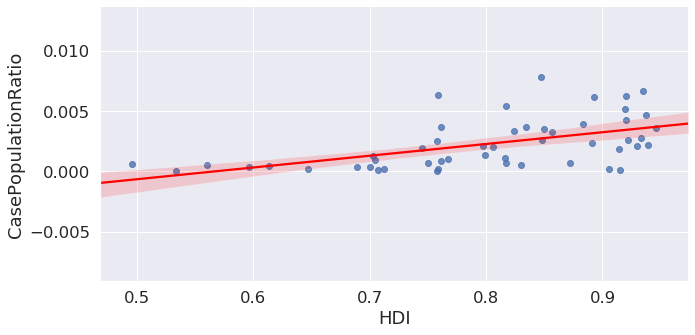

In [51]:
print("Correlation between CasePopulationRatio and HDI: " + str(df_final['CasePopulationRatio'].corr(df_final['HDI'])))
sns.lmplot(x='HDI', y='CasePopulationRatio', data=df_final, aspect=2, line_kws={'color':'red'});
f5 = plt.gcf()

Correlation between CasePopulationRatio and ObservationDays: -0.25609567028650326


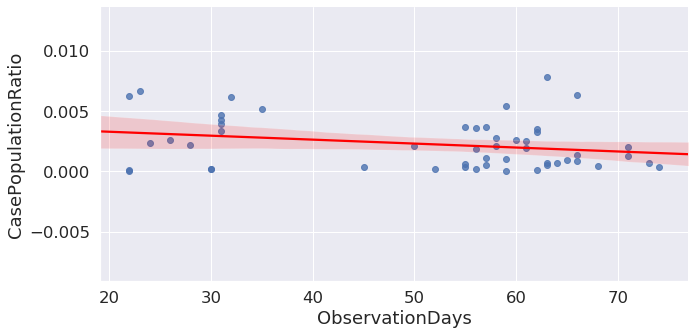

In [52]:
print("Correlation between CasePopulationRatio and ObservationDays: " + str(df_final['CasePopulationRatio'].corr(df_final['ObservationDays'])))
sns.lmplot(x='ObservationDays', y='CasePopulationRatio', data=df_final, aspect=2, line_kws={'color':'red'});
f6 = plt.gcf()

## Ethics and Privacy
The datasets are obtained from Kaggle, an open-source platform that provides datasets for public use. We are within our rights to use these datasets for our analysis.

All the statistics collected on coronavirus patients are at a national level, so no individual data is exposed or revealed. Considering the highly contagious and asymptomatic nature of COVID-19, it is important that we take a moment to consider the inevitability of unreported cases and deaths. Unfortunately, this remains a challenge worldwide as testing and medical resources are limited, so our best option is to accept that the data made available to us is very likely an underestimate of the true figures.

The HDI rankings from Wikipedia are also on a national level, so there are no concerns of individual privacy there. All articles published on Wikipedia are of public domain, meaning they can be used in any context without explicit permission of the author. The HDI is calculated and published anually by United Nations and is available for use without explicit permissions in non-commercial publications

## Conclusions & Discussion

Based on the results, a nation's HDI ranking gave us a better indication of how "successful" a nation was at handling COVID-19 compared to the date of first observation. This portion of the analysis aligns with our hypothesis. However,we found a positive correlation between a nation's HDI score and the death/case ratio rather than a negative one, leading to a spurious conclusion that nations with lower HDI scores were better equipped to minimize losses from the outbreak. When age was considered as a possible cofounding variable that drove the relationship between HDI and a higher death rate due to the nature of the demographic transition model and the HDI, we changed our dependent variable from death rate to infection rate in the hopes of limiting age from driving our conclusions. There was still a relative correlation between HDI scores and infection rate, although drastically less so when compared to death rate. The correlation between HDI and infection rate remained stronger than that between the date of first observation and infection rate.

As with most studies, there were considerable limitations and constraints that we encountered through our analysis. Firstly, it was important to recognize that the HDI ranking took into account the statistical composite index of life expectancy, education, and per capita income of a country. In our study we recognized the HDI as a whole, and not the components that made it up. Results may have varied if only a single component of the HDI ranking was considered, such as life expectancy, or if we had analyzed nations on an individual basis. Secondly, our definition as to how well a country/territory has handled the pandemic overall is rather limited in scope - there are many variables at play that extend beyond HDI or observation dates. Some nations went into lockdown and restricted travel while others did not and some reopened earlier than others due to economic and political pressures. These factors could make a significant difference in how well a nation can handle and recover losses caused by the outbreak, making it difficult/impossible to draw clear conclusions from a single figure alone. Lastly, it is important to remember that the outbreak is an **ongoing event**. Conflicting information and reports throughout the early stages of the outbreak are demonstrative of a poor general understanding of the virus and its means of transmission. Much remains unknown about COVID-19 - why some individuals exhibit severe symptoms while others see none at all, how and if symptoms bear an effect on transmission rate, and optimal methods to slow infection remain some of the most pressing questions about the virus to this day. Testing was and is still not readily available worldwide, meaning that a significant number of cases have likely gone unreported. Many experts around the world agree that current statistics on the coronavirus are a severe underestimate of the true numbers.

In conclusion, we were able to demonstrate that the HDI as an independent variable gave a better idea of infection/death rates than the date of the first observation. We expected that the virus would have a lower mortality rate on average in nations with a higher HDI primarily due to the strong relationship between HDI and life expectancy. However, this turned out to be a premature assumption as the virus has a considerably higher mortality rate in the elderly, and even after we altered our measurement from morality rate to infection rate, the positive correlation weakened signficantly but still remained.
